# Compare Models

In [1]:
import sys
sys.path.append("../")

from haxml.utils import (
    get_stadiums,
    get_matches_metadata,
    train_test_split_matches_even_count,
    get_opposing_goalpost,
    stadium_distance,
    angle_from_goal,
    is_scored_goal,
    get_positions_in_range,
    get_positions_at_time
)
from haxml.evaluation import (
    summarize_split,
    style_columns,
    make_df,
    score_model,
    run_models,
    blank_plot,
    plot_errors_by_kicks,
    plot_errors_by_goals,
    plot_xg_histogram
)
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

## Load Data and Make Train/Test Split

In [2]:
stadiums = get_stadiums("../data/stadiums.json")
metadata = get_matches_metadata("../data/matches_metadata.csv")
train, test = train_test_split_matches_even_count(metadata)

In [3]:
print("Train Data:")
summarize_split(train)
print()
print("Test Data:")
summarize_split(test)

Train Data:
Matches: 905
Goals: 2,533
Kicks: 74,882
E(XG): 0.034

Test Data:
Matches: 905
Goals: 2,539
Kicks: 74,517
E(XG): 0.034


## Feature Engineering

Add all your new features to the `generate_rows_compare()` method.

In [118]:
def shot_intersection(match,kick, stadium, offset=0):
    '''Finds where the ball would intersect
    Args:
    match: Which match it is
    kick: Which kick we want to measure
    staduim: What stadium size it is (so we know where the goals and bounds are)

    Returns:
    Int 1 or 0 if the ball is going towars the goal or not
    '''
    #Getting last frame before the kick 
    #print("Calculate intersection at time: {}".format(kick["time"] - offset))
    #frame = get_positions_at_time(match["positions"], kick["time"] - offset)
    #Using in range and tracing back to see what frame was right before it left the foot
    frame = get_positions_in_range(match["positions"], kick["time"] - offset,kick["time"])
    #A list of lists with only info about player we want and ball
    shooter_frames = []
    ball_frames = []
    #print(kick['fromName'])
    for i in frame:
        if i['name'] == kick['fromName']: 
            shooter_frames.append(i)  
        elif i['type'] == 'ball':
            ball_frames.append(i)
    #print(shooter_frames)
    #print(ball_frames)
    #picking frame with least dist
    least_dist = float('inf')
    player_position = {}
    ball_position = {}
    #List of dicts
    length = min(len(shooter_frames),len(ball_frames))
    for i in reversed(range(length-1)): #frame len of ball and shooter should be the same
        dist = stadium_distance(shooter_frames[i]['x'],shooter_frames[i]['y'],ball_frames[i]['x'],ball_frames[i]['y'])
        if dist <= least_dist:
            player_position = shooter_frames[i]
            ball_position = ball_frames[i]
        elif dist > least_dist: #stopped decreasing
            break
    #print(frame)
    #print(player_position)
    #print(ball_position)
    #Getting goal positions
    goal_mid = get_opposing_goalpost(stadium, kick['fromTeam'])['mid']
    #print(goal_mid)
     #Extend line from shot angle (can't extend lines easily)
    if(len(player_position)==0 or len(ball_position)==0):
        return None, None, None
    y_val = point_slope(
        player_position,
        slope(player_position['x'], player_position['y'], ball_position['x'], ball_position['y']),
        goal_mid['x']
    )
    #Checking if the projection between the posts
    intersect = { 'x': goal_mid['x'], 'y': y_val }
    return player_position, ball_position, intersect

In [119]:
def point_slope(p, slope,x_goal):
    #y - y1 = m(x-x1) -->  y=mx-mx1+y1 (returning the y)
    y_val = (slope*x_goal)-(slope*p['x'])+p['y'] 
    return y_val

In [120]:
def slope(x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1+1e-10)
    return m

In [121]:
def shot_on_goal(match, kick, intersect, stadium):
    '''Figuring out if shot is going into the goal or not
        Args:
            match: Which match it is
            kick: Which kick we want to measure
            intersect: x,y of the shot intersection
            stadium: Which staduim was it played on

        Returns:
                1 if shot is on goal, .5 if it hits the post, and 0 if it isn't on goal
    '''
    goal_posts = get_opposing_goalpost(stadium, kick['fromTeam'])['posts']
    if intersect['y'] > goal_posts[0]['y'] and intersect['y'] < goal_posts[1]['y']:
        return 1
    elif intersect['y'] == goal_posts[0]['y'] or intersect['y'] == goal_posts[1]['y']:
        #hits posts
        return .5
    else:
        return 0

In [122]:
def speed_player(match,kick,player_name, offset):
    '''' Speed of the player
       Args:
           match: Which match it is
           kick: Which kick we want to measure
           player_name: What player do we want to measure the speed for

        Returns:
           Int that represents the speed of the player
    '''
    #Getting time range to be able to measure distance
    #start = get_positions_at_time(match["positions"], kick["time"] - offset)
    #end = get_positions_at_time(match["positions"], kick["time"])
    #getting positions
    positions = get_positions_in_range(match["positions"], kick["time"] - offset,kick["time"])
    #print(positions)
    player_pos = []
    for i in positions:
        if i['name'] == player_name: 
            player_pos.append(i)    
    #print(player_pos)
    #Getting the time
    if len(player_pos) > 1:
        last = len(player_pos)-1#getting last index)
        time = player_pos[last]['time'] -  player_pos[0]['time'] 
        #Getting the distance 
        distance = stadium_distance(player_pos[0]['x'],player_pos[0]['y'],player_pos[last]['x'],player_pos[last]['y'])
        #dist_formula(player_pos[0]['x'],player_pos[0]['y'],player_pos[last]['x'],player_pos[last]['y'])
        #print("dist:" + str(distance))
        #print("time:" + str(time))
        #Returns speed
        #NEED TO CHANGE TIME INTO SECONDS SO THAT IT IS CONSTANT AND NOT DIVIDING BY DIFF VALS
        return distance/time
    else:
        return 0

In [123]:
def defender_feature_weighted(match,kick,stadium,dist):
    '''Figuring out the closest defender and num of defenders for a kick
        Note: This is weighted so that defenders that are close to the player/ball or the goal count as 1.5 rather than 1
        Args:
            match: Which match it is
            kick: Which kick we want to measure
            dist: Set distance to consider a player pressuring

        Returns:
                List that contains the distance of the closest defender and the number of defenders (weighted)
'''
    positions = get_positions_at_time(match["positions"], kick["time"])
    closest_defender = float('inf')
    defenders_pressuring = 0
    ret = [0,0]
    for person in positions:
        if person['team'] is not kick['fromTeam'] and person['type'] == "player": 
            defender_dist = stadium_distance(kick['fromX'],kick['fromY'],person['x'],person['y'])
            #((kick['fromX'] - person['x'])**2 + (kick['fromY'] - person['y'])**2)**(1/2)
            if defender_dist < closest_defender:
                closest_defender = defender_dist
                ret[0] = closest_defender
            if defender_dist <= dist:
                #Checking distances  for weights
                post = get_opposing_goalpost(stadium, kick['fromTeam'])
                goal_dist = stadium_distance(post['mid']['x'], post['mid']['y'] ,person['x'],person['y'])
                if defender_dist <= 5:
                    defenders_pressuring += 1.5
                elif goal_dist <= 5:
                    defenders_pressuring += 1.5
                else:
                    defenders_pressuring += 1
                ret[1] = defenders_pressuring
    return ret

In [124]:
def generate_rows_compare(match, stadium):
    """
    Generates target and features for each kick in the match.
    Produces many features for model comparison.
    Args:
        match: Inflated match data (dict).
        stadium: Stadium data (dict).
    Returns:
        Generator of dicts with values for each kick in the given match.
        Includes prediction target "ag" (actual goals) which is 1 for a scored
        goal (goal or error) and 0 otherwise, "index" which is the index of the
        kick in the match kick list, and all the other features needed for
        prediction and explanation.
    """
    for i, kick in enumerate(match["kicks"]):
        gp = get_opposing_goalpost(stadium, kick["fromTeam"])
        x = kick["fromX"]
        y = kick["fromY"]
        gx = gp["mid"]["x"]
        gy = gp["mid"]["y"]
        dist = stadium_distance(x, y, gx, gy)
        angle = angle_from_goal(x, y, gx, gy)
        player_pos, ball_pos, intersect = shot_intersection(match,kick,stadium, offset=3)
        if intersect is None:
            on_goal = 0
        else:
            on_goal = shot_on_goal(match, kick, intersect, stadium)
        name = kick['fromName']
        player_speed = speed_player(match,kick, name, offset=1)
        weighted_def = defender_feature_weighted(match,kick,stadium,dist=4)
        
        row = {
            "ag": 1 if is_scored_goal(kick) else 0,
            "index": i,
            "time": kick["time"],
            "x": x,
            "y": y,
            "goal_x": gx,
            "goal_y": gy,
            "goal_distance": dist,
            "goal_angle": angle,
            "team": kick["fromTeam"],
            "stadium": match["stadium"],
            "on_goal": on_goal,
            "player_speed": player_speed,
            "weighted_def": weighted_def
        }
        
        yield row

In [125]:
d_train = make_df(train, stadiums, generate_rows_compare, progress=True)
d_test = make_df(test, stadiums, generate_rows_compare, progress=True)

100%|██████████| 905/905 [03:47<00:00,  3.98it/s]


## Train Models

Specific all the models and feature sets you want to use below.

In [126]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [149]:
feature_sets = [
    ["goal_angle"],
    ["goal_distance"],
    ["goal_distance", "goal_angle", "on_goal","player_speed"],
]
model_params = [
    (LogisticRegression, {"random_state": 0}),
    (DecisionTreeClassifier, {}),
    (DecisionTreeClassifier, {"max_depth": 3}),
    (DecisionTreeClassifier, {"max_depth": 5}),
    (KNeighborsClassifier, {"n_neighbors": 10}),
    (KNeighborsClassifier, {"n_neighbors": 15})
]

In [150]:
df_scored = run_models(d_train, d_test, score_model, "ag", feature_sets, model_params)

Model: KNeighborsClassifier(n_neighbors=15): 100%|██████████| 18/18 [00:25<00:00,  1.43s/it]


## Rank Models By Score

Call `help()` on `score_model()` to find out what the scoring metrics mean.

In [151]:
help(score_model)

Help on function score_model in module haxml.evaluation:

score_model(d_test, target, features, clf, kwargs)
    Score a given model and return its metrics and metadata.
    Args:
        d_test: DataFrame of test data.
        target: Variable to predict (str).
        features: Columns of DataFrame to use as predictors (list of str).
        clf: Classifier (sklearn style).
        kwargs: Keyword args for classifier.
    Scores:
        accuracy: correct predictions / all records
        precision: true positives / predicted positives
        recall: true positives / actual positives
        roc_auc: area under the ROC curve (0.5 is as good as random)
        match_mae: mean absolute error between XG and AG per match
        match_rmse: root mean squared error between XG and AG per match
        xg_mean: mean of XG on dataset
        xg_std: standard deviation of XG on dataset
    Returns:
        Dictionary with fields for scoring metrics and model metadata.



In [152]:
score_color = "94, 156, 255"
style_config = {
    "accuracy": {"rgb": score_color, "low": 0, "high": 1},
    "precision": {"rgb": score_color, "low": 0, "high": 1},
    "recall": {"rgb": score_color, "low": 0, "high": 1},
    "roc_auc": {"rgb": score_color, "low": 0.5, "high": 1},
    "match_mae": {"rgb": score_color, "low": 3, "high": 0},
    "match_rmse": {"rgb": score_color, "low": 3, "high": 0},
    "xg_mean": {"rgb": score_color, "low": 0, "high": 0.07},
    "xg_std": {"rgb": score_color, "low": 0, "high": 0.5},
}

In [153]:
df_ranked = df_scored \
    .sort_values(by=["precision", "recall"], ascending=[False, False]) \
    .reset_index()
df_ranked \
    [["clf", "features"] + list(style_config.keys())] \
    .style.apply(style_columns(style_config)) \
    .set_precision(3)

,clf,features,accuracy,precision,recall,roc_auc,match_mae,match_rmse,xg_mean,xg_std
0,DecisionTreeClassifier(max_depth=3),"['goal_distance', 'goal_angle', 'on_goal', 'player_speed']",0.968,0.82,0.0626,0.531,1.49,1.83,0.0341,0.0677
1,KNeighborsClassifier(n_neighbors=10),"['goal_distance', 'goal_angle', 'on_goal', 'player_speed']",0.968,0.693,0.0898,0.544,1.43,1.77,0.0336,0.0874
2,KNeighborsClassifier(n_neighbors=15),"['goal_distance', 'goal_angle', 'on_goal', 'player_speed']",0.967,0.641,0.0902,0.544,1.42,1.76,0.0336,0.0815
3,DecisionTreeClassifier(max_depth=5),"['goal_distance', 'goal_angle', 'on_goal', 'player_speed']",0.967,0.585,0.14,0.568,1.38,1.71,0.0338,0.0783
4,LogisticRegression(random_state=0),"['goal_distance', 'goal_angle', 'on_goal', 'player_speed']",0.966,0.578,0.0437,0.521,1.39,1.76,0.0338,0.0661
5,KNeighborsClassifier(n_neighbors=10),['goal_distance'],0.965,0.365,0.024,0.511,1.53,1.88,0.0338,0.0783
6,KNeighborsClassifier(n_neighbors=15),['goal_distance'],0.965,0.354,0.0276,0.513,1.5,1.85,0.0337,0.0713
7,DecisionTreeClassifier(),"['goal_distance', 'goal_angle', 'on_goal', 'player_speed']",0.945,0.221,0.242,0.606,1.86,2.4,0.0372,0.189
8,DecisionTreeClassifier(max_depth=5),['goal_distance'],0.966,0.143,0.000394,0.5,1.48,1.81,0.0334,0.0574
9,DecisionTreeClassifier(),['goal_distance'],0.948,0.129,0.0942,0.536,1.79,2.26,0.0327,0.164


## Visualize Model Results

Model IDs are the ranks (starting from 0) of the models. We can compare the top three models with these plots.

In [132]:
models = df_ranked.to_dict(orient="records")
model_ids = [0, 1, 2]
pal = sns.hls_palette(len(model_ids))

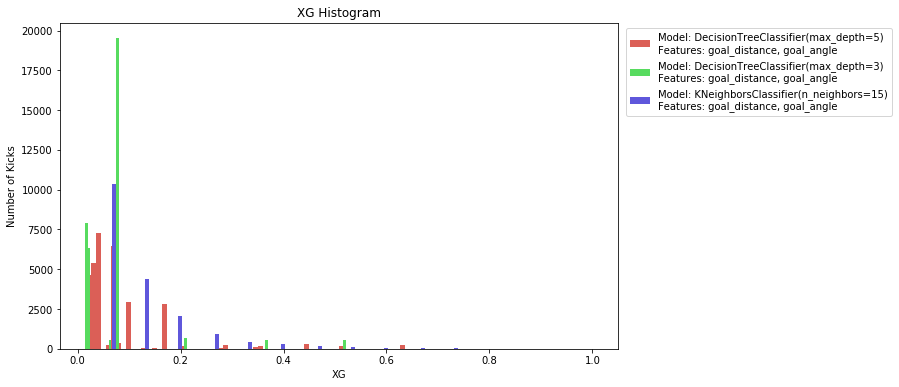

In [133]:
plot = blank_plot()
hist_kwargs = {"bins": 100}
for model_id, color in zip(model_ids, pal):
    hist_kwargs["color"] = color
    plot = plot_xg_histogram(models[model_id], d_test, plot, hist_kwargs, min_xg=1e-2)
plot[0]

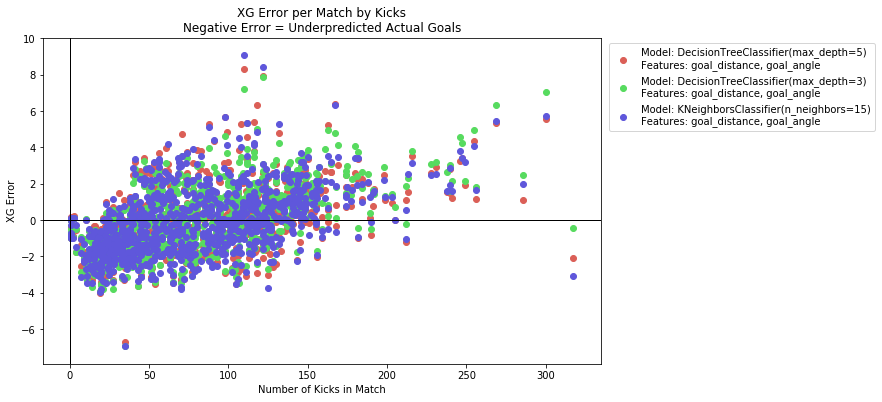

In [134]:
plot = blank_plot()
for model_id, color in zip(model_ids, pal):
    plot = plot_errors_by_kicks(models[model_id], d_test, plot, {"color": color})
plot[0]

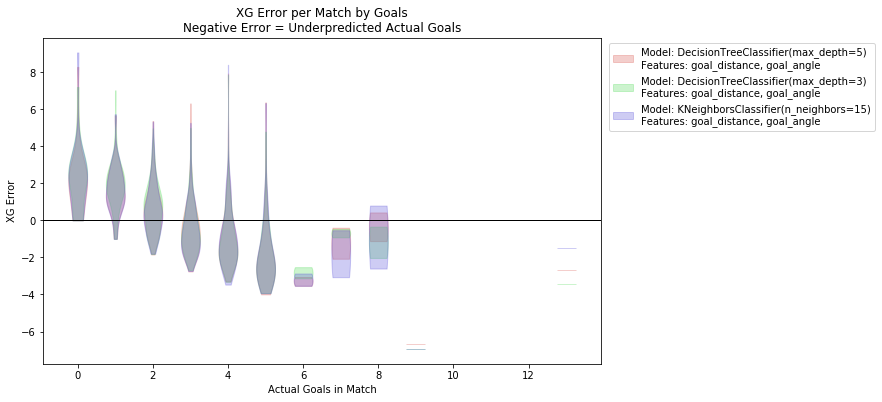

In [135]:
plot = blank_plot()
for model_id, color in zip(model_ids, pal):
    plot = plot_errors_by_goals(models[model_id], d_test, plot, {"color": color})
plot[0]